<h1><center>SMS Spam Collection : Model Testing</center></h1>
<hr>

In [1]:
import re
import os
import scipy
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

from tensorflow.keras.layers import Dense, concatenate, Activation, BatchNormalization
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D

from tensorflow.keras.layers import Input, Flatten, Embedding, LSTM
from tensorflow.keras import Model

from keras import regularizers
from keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import optimizers

Using TensorFlow backend.


In [2]:
#function 

def binary_label(x):
    if x=='ham':
        return 0
    else:
        return 1
    
def deconcatinated(x):
    x = x.lower()
    x = re.sub(r"won\'t", "will not", x)
    x = re.sub(r"won\'t", "will not", x)
    x = re.sub(r"don\'t", "do not", x)
    x = re.sub(r"shouldn\'t", "should not", x)
    x = re.sub(r"couldtn\'t", "could not", x)
    x = re.sub(r"isn\'t", "is not", x)
    x = re.sub(r"\'ll", " will", x)
    x = re.sub(r"\'d", " would", x)
    x = re.sub(r"\'m", "i am", x)
    x = re.sub(r"&", " and ", x)
    return x

def remove_punctuation(x):
    x = re.sub(r"[!\"#$%()*+,.-/:;<=>?@^_`{|}~]", " ", x)
    x = re.sub(r"\s{2,}", " ", x)
    return x

def text_length(x):
    return len(x.split())

def text_digit(x):
    return len(re.findall(r'\d+', x))

def custom_auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [3]:
def plot_model_performance(model_data):
    tr_loss = model_data.history['loss']
    tr_auc  = model_data.history['custom_auc']
    cv_loss = model_data.history['val_loss']
    cv_auc  = model_data.history['val_custom_auc']

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(tr_loss, label='Train Loss', color='orange')
    plt.plot(cv_loss, label='CV Loss', color='blue')
    plt.grid()
    plt.legend()
    plt.title('Model Loss')

    plt.subplot(122)
    plt.plot(tr_auc, label='Train AUC', color='orange')
    plt.plot(cv_auc, label='CV AUC', color='blue')
    plt.grid()
    plt.legend()
    plt.title('Model AUC')

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(actual, predicted):
    """
    for plotting confusion matrix for predicted and actual class labels
    """
    C = confusion_matrix(actual, predicted) #confusion matrix
    A = ((C.T)/(C.sum(axis=1))).T           #recall matrix    (row sum=1)
    B = (C/C.sum(axis=0))                   #precision matrix (col sum=1)
    labels = list(range(2))

    plt.figure(figsize=(15, 5))
    
    ax1=plt.subplot(131)
    #print('-'*10, 'Confusion Matrix', '-'*10)
    #plt.figure(figsize=(5, 4))
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax2=plt.subplot(132)
    #print('-'*10, 'Precision Matrix (ColSum=1)', '-'*10)#B
    #plt.figure(figsize=(5, 4))
    sns.heatmap(B, annot=True, cmap='YlGn', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_title('Precision Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax3=plt.subplot(133)
    #print('-'*10, 'Recall Matrix (RowSum=1)', '-'*10)#A
    #plt.figure(figsize=(5, 4))
    sns.heatmap(A, annot=True, cmap='YlOrBr', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax3)
    ax3.set_title('Recall Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    plt.tight_layout()
    plt.show()

In [4]:
def embed_lstm_model(vocab_size, shape, print_summary=False):
    model_input    = Input(shape=(shape, ), name='model_input')
    text_embeding  = Embedding(vocab_size, 300, #weights=[x_tr_embeding_matrix], \
                               input_length=shape, trainable=True, name='text_embeding')(model_input)
    lstm_layer1    = LSTM(64, name='lstm_layer1')(text_embeding)
    dense_layer1   = Dense(64, activation='relu', name='dense_layer1')(lstm_layer1)
    dropout_layer1 = Dropout(0.2, name='dropout_layer1')(dense_layer1)
    dense_layer2   = Dense(1, name='final_prediction')(dropout_layer1)
    lstm_model     = Model(inputs=model_input,outputs=dense_layer2)
    lstm_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-3) ,metrics=[custom_auc])
    if print_summary:
        lstm_model.summary()
    return lstm_model

def model_prediction(clf, data, actual_labels):
    prediction_probs = clf.predict(data)
    prediction       = [ 0 if x < 0 else 1 for x in prediction_probs ]
    plot_confusion_matrix(actual_labels, prediction)
    return prediction

In [5]:
batch = 128
epoch = 10
text_max_length = 30

checkpoint = ModelCheckpoint("./SMS_Classification/LSTM_Embeded_Text_Num_feat_Model.h5",monitor="val_custom_auc",\
                             mode="max",save_best_only = True,verbose=1)

stop_early = EarlyStopping(monitor='val_custom_auc', min_delta=0, patience=25, verbose=0, mode='max', \
                           restore_best_weights=True)

## [1] Training the model

In [6]:
def sms_classification_train():
    if not os.path.isfile('./SMS_Classification/SMS_Classification_filtered.csv'):
        print('Processing file...')
        file = './raw_data/spam.csv'
        data = pd.read_csv(file, encoding="ISO-8859-1")[['v1', 'v2']]
        
        #changing the class label into numerical
        df['Label'] = df['v1'].map(binary_label)
        
        filtered_text = list()
        for line in tqdm(df['v2'].values):
            line = remove_punctuation(line)
            line = deconcatinated(line)
            filtered_line = list()
            for word in line.split():
                #if (word.lower() not in stop) and (word.lower().isalpha()):
                if (word.lower().isalnum()):
                    filtered_line.append(word.lower())
            #print(filtered_line)
            filtered_text.append(' '.join(filtered_line))
        #making new column with cleaned text    
        df['filtered_text'] = filtered_text
        
        #finalizing the data
        data = df[['filtered_text', 'Label']]
        
        #New Feature  :  Text Length
        data['text_length'] = data['filtered_text'].map(text_length)
        
        #New Length  :  Presence of Digit
        data['presence_of_digit'] = data['filtered_text'].map(text_digit)
        
        print('Number of NULL records ', data.isna().sum())
        
        #making new directory for future runs
        if not os.path.isdir('SMS_Classification'):
            os.mkdir('SMS_Classification')
        #saving filtered text data
        data = data.fillna(' ', axis=1)
        data.to_csv('./SMS_Classification/SMS_Classification_filtered.csv', index=False)
    else:
        print('Loading data from file...')
        data = pd.read_csv('./SMS_Classification/SMS_Classification_filtered.csv')
    
    # *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    data = data.fillna(' ', axis=1)
    #data splitting
    x_tr, x_cv, y_tr, y_cv = train_test_split(data.drop('Label', axis=1), data['Label'], stratify=data['Label'], \
                                         test_size=0.10, random_state=47)
    #tokenizing text words
    token = Tokenizer()
    token.fit_on_texts(x_tr['filtered_text'].values)
    vocab_size   = len(token.word_index) + 1
    x_tr_encoded = token.texts_to_sequences(x_tr['filtered_text'].values)
    x_cv_encoded = token.texts_to_sequences(x_cv['filtered_text'].values)
    
    #pad each sentence with total of max (max_length) sized words
    max_length = text_max_length
    x_tr_padded = pad_sequences(x_tr_encoded, maxlen=max_length, padding='post')
    x_cv_padded = pad_sequences(x_cv_encoded, maxlen=max_length, padding='post')
    #stacking vectorized features
    tr_text_num_feat = np.hstack((x_tr_padded, x_tr[['text_length', 'presence_of_digit']]))
    cv_text_num_feat = np.hstack((x_cv_padded, x_cv[['text_length', 'presence_of_digit']]))
    #loading LSTM model
    print('Loading LSTM Model...\n')
    lstm_model = embed_lstm_model(vocab_size, tr_text_num_feat.shape[1], print_summary=False)
    #fitting the model on given data
    history = lstm_model.fit(tr_text_num_feat, y_tr, batch_size=batch, epochs=epoch, \
                             validation_data=(cv_text_num_feat, y_cv), use_multiprocessing=True, \
                             callbacks=[checkpoint, stop_early])
    plot_model_performance(history)
    
    #loading best weights to model structure
    lstm_model = embed_lstm_model(vocab_size, tr_text_num_feat.shape[1], print_summary=True)
    lstm_model.load_weights('./SMS_Classification/LSTM_Embeded_Text_Num_feat_Model.h5')
    
    #performance of model with calculation of AUC on Train and Cross Validation data
    tr_loss, tr_auc = lstm_model.evaluate(tr_text_num_feat, y_tr, batch_size=batch)
    cv_loss, cv_auc = lstm_model.evaluate(cv_text_num_feat, y_cv, batch_size=batch)
    
    print('\nPerformance of Model on\nTrain Data            :::  Loss={0}, AUC={1}\nCross validation Data :::  Loss={2}, AUC={3}\n'\
          .format(round(tr_loss, 5), round(tr_auc, 5), round(cv_loss, 5), round(cv_auc,5) ))

Loading data from file...
Loading LSTM Model...

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.3918 - custom_auc: 0.7459
Epoch 00001: val_custom_auc improved from -inf to 0.99631, saving model to ./SMS_Classification\LSTM_Embeded_Text_Num_feat_Model.h5
40/40 [==============================] - 6s 153ms/step - loss: 0.3918 - custom_auc: 0.7459 - val_loss: 0.0606 - val_custom_auc: 0.9963
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.1352 - custom_auc: 0.9898
Epoch 00002: val_custom_auc did not improve from 0.99631
40/40 [==============================] - 5s 115ms/step - loss: 0.1352 - custom_auc: 0.9898 - val_loss: 0.1936 - val_custom_auc: 0.9932
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.0805 - custom_auc: 0.9918
Epoch 00003: val_custom_auc improved from 0.99631 to 0.99635, saving model to ./SMS_Classification\LSTM_Embeded_Text_Num_feat_Model.h5
40/40 [==============================] - 5s 126ms/step - loss: 0.0805

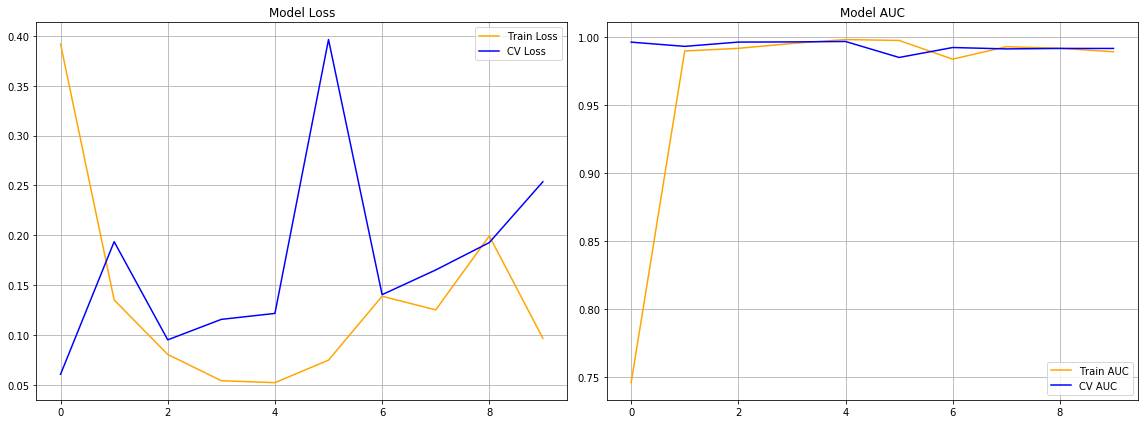

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 32)]              0         
_________________________________________________________________
text_embeding (Embedding)    (None, 32, 300)           2417100   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 64)                93440     
_________________________________________________________________
dense_layer1 (Dense)         (None, 64)                4160      
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 64)                0         
_________________________________________________________________
final_prediction (Dense)     (None, 1)                 65        
Total params: 2,514,765
Trainable params: 2,514,765
Non-trainable params: 0
____________________________________________

In [7]:
sms_classification_train()

## [2] Testing a Sample SMSs

In [8]:
def sms_classification_prediction(record):
    if not os.path.isfile('./SMS_Classification/SMS_Classification_filtered.csv'):
        sms_classification_train()
    else:
        #print('Loading data from file...')
        data = pd.read_csv('./SMS_Classification/SMS_Classification_filtered.csv')
        data = data.fillna(' ', axis=1)
        
        x_tr, x_cv, y_tr, y_cv = train_test_split(data.drop('Label', axis=1), data['Label'], \
                                      stratify=data['Label'], \
                                      test_size=0.10, random_state=47)
        #tokenizing text words
        token = Tokenizer()
        token.fit_on_texts(x_tr['filtered_text'].values)
        vocab_size   = len(token.word_index) + 1
        
    #encoding the test SMS sentence
    test_record = list()
    test_record.append(record)
    #pre-process test record
    my_text = pd.DataFrame(test_record, columns=['text'])
    
    filtered_text = list()
    for line in my_text['text'].values:
        line = remove_punctuation(line)
        line = deconcatinated(line)
        filtered_line = list()
        for word in line.split():
            if (word.lower().isalnum()):
                filtered_line.append(word.lower())
        filtered_text.append(' '.join(filtered_line))
    my_text['filtered_text'] = filtered_text
    
    my_text['text_length'] = data['filtered_text'].map(text_length)
    
    my_text['presence_of_digit'] = data['filtered_text'].map(text_digit)
    
    #converting into numerical sequences
    max_length=text_max_length
    encoded = token.texts_to_sequences(my_text['filtered_text'].values)
    padded  = pad_sequences(encoded, maxlen=max_length, padding='post')
    
    output_text = np.hstack((padded, my_text[['text_length', 'presence_of_digit']]))
    
    #print('Loading LSTM Model...\n')
    lstm_model = embed_lstm_model(vocab_size, output_text.shape[1], print_summary=False)
    lstm_model.load_weights('./SMS_Classification/LSTM_Embeded_Text_Num_feat_Model.h5')
    
    #lst_model.predict(output_text)
    #return (my_text, output_text, lstm_model)
    model_prob = lstm_model.predict(output_text).tolist()[0][0]
    if model_prob>0:
        print('This is SPAM SMS')
        return 1
    else:
        print("This is HAM SMS")
        return 0

## [3] Sample Run

#### [3.1] Example 1 

In [9]:
sms_text = 'Well done. You have free membership in your cart. Please reach out to us at 9100000000'

In [10]:
response = sms_classification_prediction(sms_text)

This is SPAM SMS


#### [3.2] Example 2

In [11]:
sms_text = "Hey man, come and get your parcel. I've kept it in my locker"

In [12]:
response = sms_classification_prediction(sms_text)

This is HAM SMS


<hr>